# Анализ пользовательской активности и популярности событий (Осень 2024)

## Цели проекта
Провести исследовательский анализ данных, чтобы дать ответы на вопросы о том как менялось пользовательские предпочтения и активности осенью 2024 года.
Проанализировать популярность событий по регионам, партнёрам и категориям мероприятий.Проверить гипотезы о различиях в поведении пользователей мобильных и стационарных устройств.

## Описание данных
Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. 

* order_id — уникальный идентификатор заказа.
* user_id — уникальный идентификатор пользователя.
* created_dt_msk — дата создания заказа (московское время).
* created_ts_msk — дата и время создания заказа (московское время).
* event_id — идентификатор мероприятия из таблицы events.
* cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
* age_limit — возрастное ограничение мероприятия.
* currency_code — валюта оплаты, например rub для российских рублей.
* device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
* revenue — выручка от заказа.
* service_name — название билетного оператора.
* tickets_count — количество купленных билетов.
* total — общая сумма заказа.
* days_since_prev - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 
* event_id — уникальный идентификатор мероприятия.
* event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
* event_type_description — описание типа мероприятия.
* event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
* organizers — организаторы мероприятия.
* region_name — название региона.
* city_name — название города.
* venue_id — уникальный идентификатор площадки.
* venue_name — название площадки.
* venue_address — адрес площадки.

Выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Датасет final_tickets_tenge_df.csv содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
* nominal — номинал (100 тенге).
* data — дата.
* curs — курс тенге к рублю.
* cdx — обозначение валюты (kzt).

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

In [2]:
try:
    orders = pd.read_csv('final_tickets_orders_df.csv')
except FileNotFoundError:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv');

try:
    events = pd.read_csv('final_tickets_events_df.csv')
except FileNotFoundError:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv');
    
try:
    tenge_df = pd.read_csv('final_tickets_tenge_df.csv')
except FileNotFoundError:
    tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv');

In [3]:
orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Датасет orders содержит 14 столбцов и 290848 строк, в котором представленна информация обо всех заказах, совершённых с двух типов устройств — мобильных и стационарны. Пропуски содержаться только в столбце days_since_prev, в котором количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск. Данные хранятся в трех типах данных - float64б, int64, object. Название столбцов написанно корректно и не требует доработки. 

In [5]:
events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Датасет events содержит 11 столбцов и 22426 строк, в котором представленна информация о событиях и мероприятиях, включая город и регион события Пропусков нет, название столбцов написанно правильно. Данные хранятся в двух типах данных - int64, object. 

In [7]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датасет tenge_df имеет 4 столбца и 356 строк. Содержится информация о том как менялся курс рубля к тенге.

In [9]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [10]:
orders_events_df = pd.merge(orders, events, on='event_id')

In [11]:
orders_events_df.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64

In [12]:
round(orders_events_df['days_since_prev'].isna().mean() * 100, 2)

7.54

Пропуски содержаться только в столбце days_since_prev и составляют 7% от данных

In [13]:
orders_events_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"


In [14]:
for column in ['cinema_circuit','currency_code', 'event_type_description', 'event_type_main', 'region_name', 'city_name', 'venue_name', 'venue_address']:
    print(f"{column}:{orders_events_df[column].unique()}")

cinema_circuit:['нет' 'Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм']
currency_code:['rub' 'kzt']
event_type_description:['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']
event_type_main:['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
region_name:['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'Лесодальний край' 'Верхоречная область' 'Горицветская область'
 'Речиновская область' 'Травиницкий округ' 'Сосновская область'
 'Серебринская область' 'Травяная область' 'Каменноярский край'
 'Сол

In [15]:
for column in ['cinema_circuit','currency_code', 'event_type_description', 'event_type_main', 'region_name', 'city_name', 'venue_name', 'venue_address']:
    orders_events_df[column] = orders_events_df[column].str.lower().str.strip()

In [16]:
missing_values = ['','unknown','n/a','не указано']
for column in ['cinema_circuit','currency_code', 'event_type_description', 'event_type_main', 'region_name', 'city_name', 'venue_name', 'venue_address']:
   print(orders_events_df[column].isin(missing_values).sum())

0
0
0
0
0
0
0
0


In [17]:
orders_events_df['created_dt_msk'] = pd.to_datetime(orders_events_df['created_dt_msk'])
orders_events_df['created_ts_msk'] = pd.to_datetime(orders_events_df['created_ts_msk'])
for columns in ['order_id','event_id','event_id','age_limit','tickets_count','city_id','venue_id']:
    orders_events_df[columns] = pd.to_numeric(orders_events_df[columns], downcast='integer')
for columns in ['revenue', 'total', 'days_since_prev']:
    orders_events_df[columns] = pd.to_numeric(orders_events_df[columns], downcast='integer')

На данном этапе проведена предварительная подготовка данных:
проверено наличие пропусков и выявлены потенциальные аномалии,
названия столбцов приведены к единому стилю для удобства работы,
выполнены необходимые преобразования типов данных для корректной работы с метриками,
оптимизировано использование памяти за счёт снижения кратности числовых колонок.

In [18]:
orders_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

In [19]:
rub_df = orders_events_df[orders_events_df['currency_code']=='rub']
kzt_df = orders_events_df[orders_events_df['currency_code']=='kzt']
rub_df['revenue'].describe()

count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

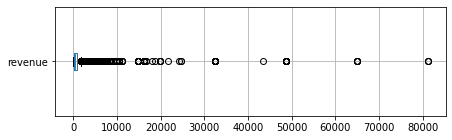

In [20]:
plt.figure(figsize=(7, 2))
rub_df.boxplot(column= 'revenue', vert=False);

285 542 заказов — много данных, статистика надёжна.
548 ₽ — средняя выручка на заказ.
872 ₽ — стандартное отклонение очень большое,это говорит о сильной вариативности и возможных выбросах.
min: -90,76 ₽ — отрицательная выручка возможно означают возвраты.
25%, 50%, 75%: медиана 346 ₽, верхний квартиль 793 ₽ — 50% заказов ниже 346 ₽.
max: 81 174 ₽ — крайне высокий заказ, выбивающийся из общей массы, это выброс.
Данные сильно скошены вправо: большинство заказов небольшие, а есть редкие очень большие.
Наличие отрицательных и очень больших значений делает среднее значение менее информативным — медиана и квартильные значения более надёжны.

In [21]:
kzt_df['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

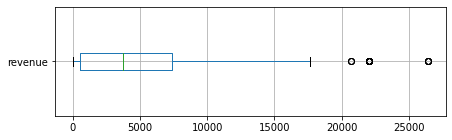

In [22]:
plt.figure(figsize=(7, 2))
kzt_df.boxplot(column= 'revenue', vert=False);

Есть нулевой заказ (min = 0), который, возможно, стоит исключить из анализа.
Среднее (mean) выше медианы (50%), значит, есть выбросы — очень дорогие заказы, которые повышают среднее.
Стандартное отклонение (std) тоже большое — распределение выручки сильно разрежено и с длинным хвостом справа.

In [23]:
rub_clear = rub_df[
    (rub_df['revenue'] > rub_df['revenue'].quantile(0.01)) & 
    (rub_df['revenue'] < rub_df['revenue'].quantile(0.99))
]
kzt_clear = kzt_df[
    (kzt_df['revenue'] > kzt_df['revenue'].quantile(0.01)) & 
    (kzt_df['revenue'] < kzt_df['revenue'].quantile(0.99))
]

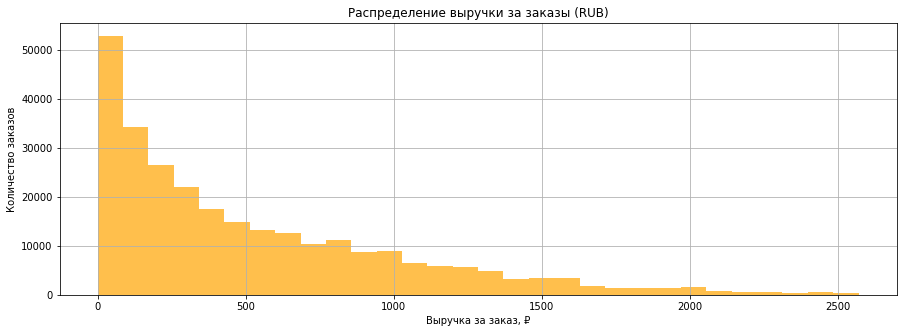

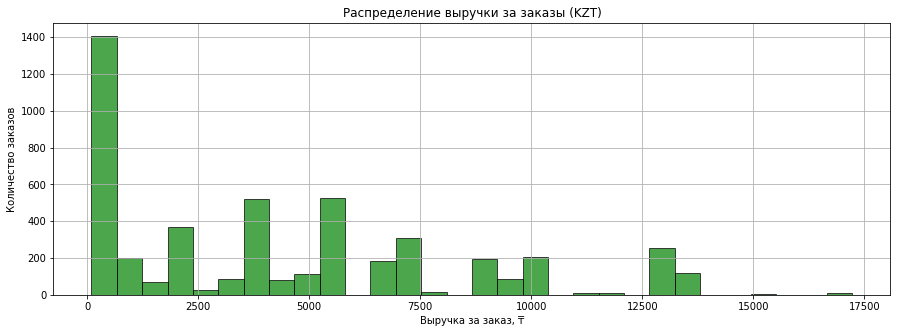

In [24]:
plt.figure(figsize=(15,5))
rub_clear['revenue'].plot(kind='hist', bins=30, alpha=0.7, color='orange')
plt.title('Распределение выручки за заказы (RUB)')
plt.xlabel('Выручка за заказ, ₽')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
kzt_clear['revenue'].plot(kind='hist', bins=30, alpha=0.7, edgecolor='black', color='green')
plt.title('Распределение выручки за заказы (KZT)')
plt.xlabel('Выручка за заказ, ₸')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

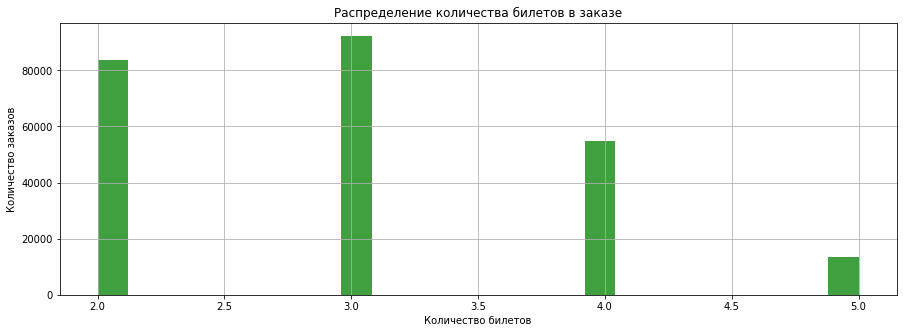

In [25]:
tickets_clear = orders_events_df[
    (orders_events_df['tickets_count'] > orders_events_df['tickets_count'].quantile(0.01)) &
    (orders_events_df['tickets_count'] < orders_events_df['tickets_count'].quantile(0.99))
].sort_values('tickets_count')

plt.figure(figsize=(15, 5))
tickets_clear['tickets_count'].plot(
    kind='hist', 
    bins=25, 
    alpha=0.75, 
    color='green'
)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

In [26]:
orders_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

In [27]:
orders_events_df.duplicated().sum() 

0

In [28]:
group_cols = ['user_id', 'event_id', 'created_dt_msk']
df_sorted = orders_events_df.sort_values(by=group_cols + ['revenue'], ascending=True)
df_clear = df_sorted.drop_duplicates(subset=group_cols, keep='last')
print(f"До очистки: {orders_events_df.shape[0]} строк")
print(f"После очистки: {df_clear.shape[0]} строк")
print(f"Удалено {orders_events_df.shape[0] - df_clear.shape[0]} возможных дубликатов")
df_clear.head()

До очистки: 290611 строк
После очистки: 191413 строк
Удалено 99198 возможных дубликатов


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6"
40,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,каменевский регион,глиногорск,213,2941,"музыкальная школа для детей ""аккаунт"" лтд","алл. шмидта, д. 9 стр. 4"
119,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,каменевский регион,глиногорск,213,4507,"училище искусств ""нирвана"" инк","алл. юбилейная, д. 5/6"
175,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,североярская область,озёрск,2,3574,"театр альтернативного искусства ""ода"" лимитед","алл. есенина, д. 243 к. 3/8"
767,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,...,9cc55c15-4375-4129-9979-3129688ba1b4,концерт,концерты,№1020,лугоградская область,кристалевск,193,930,"школа живописи ""солнце"" групп","бул. отрадный, д. 4 стр. 1"


Основные действия:
Отсортированы данные по user_id, event_id, created_dt_msk и revenue в порядке возрастания.
Удалены дубликаты, оставляя строку с максимальной выручкой (revenue) для каждой комбинации user_id, event_id, created_dt_msk.

In [29]:
df_clear = df_clear.merge(
    tenge_df[['data', 'curs']],
    how='left',
    left_on='created_dt_msk',
    right_on='data'
).drop(columns=['data'])

In [30]:
def to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        return row['revenue'] / (row['curs'] / 100)
    else:
        return None

df_clear['revenue_rub'] = df_clear.apply(to_rub, axis=1)

Привели все данные к единой валюте

In [31]:
df_clear['one_ticket_revenue_rub'] = df_clear['revenue_rub'] / df_clear['tickets_count']
df_clear['one_ticket_revenue_rub'].head()

0    380.485000
1    144.725000
2    314.642500
3      4.245000
4    300.913333
Name: one_ticket_revenue_rub, dtype: float64

In [32]:
df_clear['month'] = df_clear['created_dt_msk'].dt.month
df_clear['month'].head()

0     8
1     7
2    10
3     7
4    10
Name: month, dtype: int64

In [33]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_clear['season'] = df_clear['month'].apply(get_season)
df_clear['season'].head()

0     лето
1     лето
2    осень
3     лето
4    осень
Name: season, dtype: object

Добавили новые столбцы:
* one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие,
* month — отдельный столбец c месяцем оформления заказа,
* season — столбец с информацией о сезонности, включающий такие категории, как: 'лето', 'осень', 'зима', 'весна'.

#### Вывод по этапу предобработки данных

Перед анализом данные были тщательно подготовлены:
* проведена первичная проверка на пропуски и дубликаты — удалены некорректные и повторяющиеся записи.
* приведены к нужным типам данные по датам, количеству заказов и стоимости.
* обработаны аномальные значения — исключены нереалистично высокие или низкие цены и заказы.
* добавлены вспомогательные столбцы (например сезон, месяц), чтобы лучше отследить динамику пользовательской активности.
* объединены данные из разных таблиц, что позволило анализировать заказы в контексте мероприятий, географии, типа устройства.

Таким образом, данные приведены к чистому, структурированному виду, пригодному для анализа пользовательского поведения, сезонных трендов и проверки гипотез.

In [34]:
##Исследовательский анализ данных

In [35]:
###Анализ распределения заказов по сегментам и их сезонные изменения

In [36]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191413 entries, 0 to 191412
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                191413 non-null  int32         
 1   user_id                 191413 non-null  object        
 2   created_dt_msk          191413 non-null  datetime64[ns]
 3   created_ts_msk          191413 non-null  datetime64[ns]
 4   event_id                191413 non-null  int32         
 5   cinema_circuit          191413 non-null  object        
 6   age_limit               191413 non-null  int8          
 7   currency_code           191413 non-null  object        
 8   device_type_canonical   191413 non-null  object        
 9   revenue                 191413 non-null  float64       
 10  service_name            191413 non-null  object        
 11  tickets_count           191413 non-null  int8          
 12  total                   191413

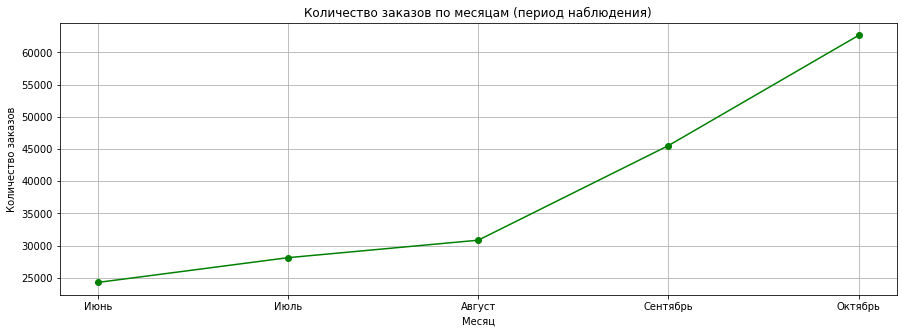

   month  order_count month_name
0      6        24289       Июнь
1      7        28131       Июль
2      8        30844     Август
3      9        45521   Сентябрь
4     10        62628    Октябрь


In [37]:
count_order_month = df_clear.groupby('month')['order_id'].count().reset_index()
count_order_month.columns = ['month', 'order_count']

count_order_month = count_order_month[count_order_month['order_count'] > 0]

months_names = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май',
    6: 'Июнь', 7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь',
    11: 'Ноябрь', 12: 'Декабрь'
}
count_order_month['month_name'] = count_order_month['month'].map(months_names)

plt.figure(figsize=(15, 5))
plt.plot(count_order_month['month_name'], count_order_month['order_count'], marker='o', color='green')
plt.title('Количество заказов по месяцам (период наблюдения)')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

print(count_order_month)


На графике представлена динамика количества заказов за период с июня по октябрь. В летние месяцы наблюдается постепенный рост активности пользователей, который сменяется более заметным скачком в осенний период.

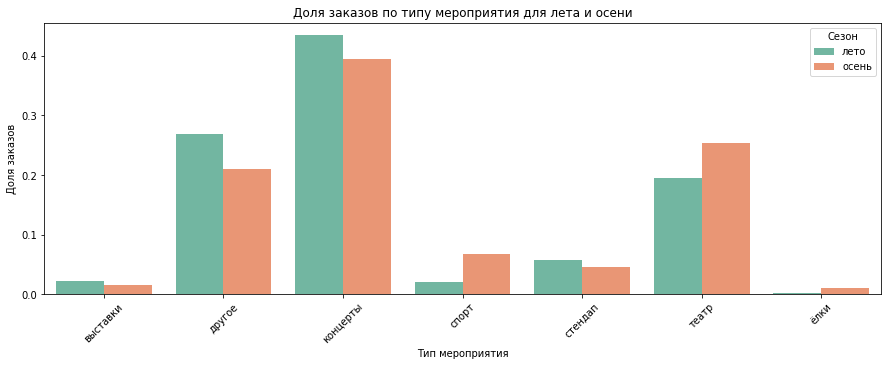

   season event_type_main  order_id     share
0    лето        выставки      1810  0.021738
1    лето          другое     22413  0.269180
2    лето        концерты     36128  0.433897
3    лето           спорт      1763  0.021174
4    лето         стендап      4736  0.056879
5    лето           театр     16217  0.194766
6    лето            ёлки       197  0.002366
7   осень        выставки      1738  0.016070
8   осень          другое     22765  0.210497
9   осень        концерты     42673  0.394576
10  осень           спорт      7373  0.068174
11  осень         стендап      4960  0.045863
12  осень           театр     27503  0.254307
13  осень            ёлки      1137  0.010513


In [38]:
df_season = df_clear[df_clear['season'].isin(['лето', 'осень'])]
count_event_season = df_season.groupby(['season', 'event_type_main'])['order_id'].count().reset_index()
total_per_season = count_event_season.groupby('season')['order_id'].transform('sum')
count_event_season['share'] = count_event_season['order_id'] / total_per_season
plt.figure(figsize=(15,5))
sns.barplot(
    data=count_event_season, 
    x='event_type_main', 
    y='share', 
    hue='season',
    palette='Set2'
)
plt.title('Доля заказов по типу мероприятия для лета и осени')
plt.ylabel('Доля заказов')
plt.xlabel('Тип мероприятия')
plt.xticks(rotation=45)
plt.legend(title='Сезон')
plt.show()
print(count_event_season)

Летом наибольшая доля заказов приходилась на концерты (≈43%) и театры (≈19%), тогда как осенью их соотношение несколько изменилось: концерты сохранили лидерство (≈39%), но доля театров выросла до ≈25%, а также заметно увеличился интерес к спортивным мероприятиям (с 2% до 7%).

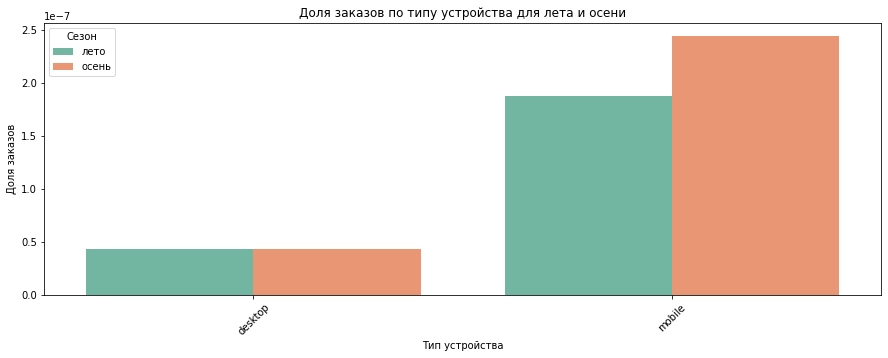

  season device_type_canonical  order_id         share
0   лето               desktop     15610  4.323285e-08
1   лето                mobile     67654  1.873719e-07
2  осень               desktop     20000  4.292402e-08
3  осень                mobile     88149  2.441340e-07


In [39]:
df_season = df_clear[df_clear['season'].isin(['лето', 'осень'])]
count_device_type_season = df_season.groupby(['season','device_type_canonical'])['order_id'].count().reset_index()
count_total_order = df_season.groupby('season')['order_id'].transform('sum')
count_device_type_season['share'] = count_device_type_season['order_id'] / count_total_order
plt.figure(figsize=(15,5))
sns.barplot(
    data=count_device_type_season, 
    x='device_type_canonical', 
    y='share', 
    hue='season',
    palette='Set2'
)
plt.title('Доля заказов по типу устройства для лета и осени')
plt.ylabel('Доля заказов')
plt.xlabel('Тип устройства')
plt.xticks(rotation=45)
plt.legend(title='Сезон')
plt.show()
print(count_device_type_season)

Мобильные устройства уверенно доминируют на протяжении всего периода — на них приходится более 80% заказов как летом, так и осенью. При этом осенью активность выросла у обеих категорий устройств: количество заказов с мобильных устройств увеличилось примерно на 30%, а с десктопов — на ≈28%.

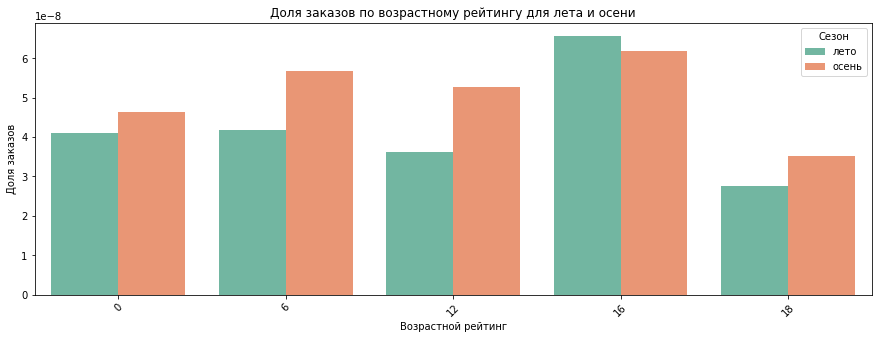

  season  age_limit  order_id         share
0   лето          0     14791  4.096458e-08
1   лето          6     15061  4.171236e-08
2   лето         12     16872  3.621071e-08
3   лето         16     23719  6.569122e-08
4   лето         18     12821  2.751645e-08
5  осень          0     21597  4.635151e-08
6  осень          6     20511  5.680646e-08
7  осень         12     24511  5.260554e-08
8  осень         16     28859  6.193722e-08
9  осень         18     12671  3.509311e-08


In [40]:
df_season = df_clear[df_clear['season'].isin(['лето', 'осень'])]
count_age_season = df_season.groupby(['season','age_limit'])['order_id'].count().reset_index()
count_total_order = df_season.groupby('season')['order_id'].transform('sum')
count_age_season['share'] = count_age_season['order_id'] / count_total_order
plt.figure(figsize=(15,5))
sns.barplot(
    data=count_age_season, 
    x='age_limit', 
    y='share', 
    hue='season',
    palette='Set2'
)
plt.title('Доля заказов по возрастному рейтингу для лета и осени')
plt.ylabel('Доля заказов')
plt.xlabel('Возрастной рейтинг')
plt.xticks(rotation=45)
plt.legend(title='Сезон')
plt.show()
print(count_age_season)

И летом, и осенью наибольшее количество заказов приходится на мероприятия с возрастным ограничением 16+, что говорит о высокой активности подростковой и взрослой аудитории.

Осенью наблюдается рост числа заказов во всех возрастных категориях, особенно в сегментах 0+, 6+ и 12+

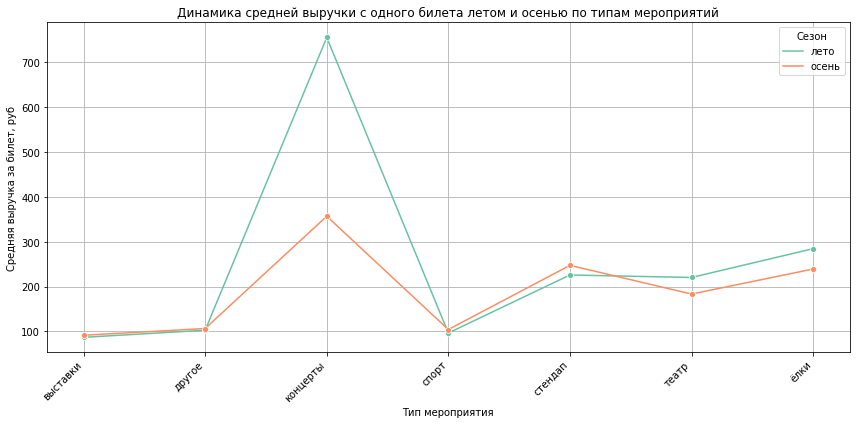

   event_type_main season  one_ticket_revenue_rub
0         выставки   лето               86.979841
1         выставки  осень               91.551693
2           другое   лето              102.747240
3           другое  осень              106.619692
4         концерты   лето              755.208447
5         концерты  осень              356.835093
6            спорт   лето               96.624011
7            спорт  осень              104.357645
8          стендап   лето              225.911462
9          стендап  осень              247.379394
10           театр   лето              220.333689
11           театр  осень              183.425061
12            ёлки   лето              284.532604
13            ёлки  осень              239.205961


In [41]:
df_season = df_clear[df_clear['season'].isin(['лето', 'осень'])]
avg_ticket_event = (
    df_season
    .groupby(['event_type_main', 'season'])['one_ticket_revenue_rub']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_ticket_event,
    x='event_type_main',
    y='one_ticket_revenue_rub',
    hue='season',
    marker='o',
    palette='Set2'
)
plt.title('Динамика средней выручки с одного билета летом и осенью по типам мероприятий')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка за билет, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(title='Сезон')
plt.tight_layout()
plt.show()

print(avg_ticket_event)

#### Средняя стоимость билета заметно различается в зависимости от категории события и сезона.

Концерты демонстрируют самое сильное снижение среднего чека — с ≈755 ₽ летом до ≈357 ₽ осенью, что может говорить о росте массовых мероприятий с более доступной ценой. Театр также показывает небольшое снижение стоимости билета — с 220 ₽ до 183 ₽, вероятно, за счёт увеличения доли популярных, но более бюджетных постановок.
В категориях «спорт», «стендап», «другое» и «выставки» наблюдается рост среднего чека, что указывает на повышение интереса к этим форматам и готовность аудитории платить больше.
Категория «ёлки» сохраняет высокую цену билетов, но осенью (до начала праздничного сезона) средний чек немного снижается.

In [42]:
avg_ticket_pivot = (
    avg_ticket_event
    .pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub')
    .reset_index()
)
avg_ticket_pivot['change_%'] = ((avg_ticket_pivot['осень'] - avg_ticket_pivot['лето']) / avg_ticket_pivot['лето']) * 100
avg_ticket_pivot = avg_ticket_pivot.sort_values('change_%', ascending=False)
avg_ticket_pivot.columns = ['Тип мероприятия', 'Средняя выручка с одного билета летом, ₽', 'Средняя выручка с одного билета осенью, ₽', 'Изменение, %']
avg_ticket_pivot.style.background_gradient(subset=['Изменение, %'], cmap='Oranges', low=0, high=0.3)\
                  .format({'Средняя выручка летом, ₽': '{:,.0f}', 
                           'Средняя выручка осенью, ₽': '{:,.0f}', 
                           'Изменение, %': '{:+.1f}%'})


,Тип мероприятия,"Средняя выручка с одного билета летом, ₽","Средняя выручка с одного билета осенью, ₽","Изменение, %"
4,стендап,225.911462,247.379394,+9.5%
3,спорт,96.624011,104.357645,+8.0%
0,выставки,86.979841,91.551693,+5.3%
1,другое,102.747240,106.619692,+3.8%
6,ёлки,284.532604,239.205961,-15.9%
5,театр,220.333689,183.425061,-16.8%
2,концерты,755.208447,356.835093,-52.8%


### Динамика количества заказов по месяцам

С июня по октябрь 2024 года наблюдается устойчивый рост числа заказов:
Июнь — 24,289 заказов;
Июль — 28,131 заказов;
Август — 30,844 заказов;
Сентябрь — 45,521 заказов;
Октябрь — 62,628 заказов.
Рост заказов более чем в два раза с июня по октябрь говорит о том, что пользовательская активность заметно увеличивается с началом осеннего сезона. Это может быть связано как с повышением интереса к событиям после летнего периода, так и с запуском осенних мероприятий и акций.

#### Изменение распределения заказов по типам мероприятий
Сравнение летнего и осеннего сезонов показывает следующие изменения:
Доля заказов на спортивные события выросла с 2,1% до 6,8%, что говорит о возросшем интересе к спорту в осенний период;
Доля заказов на театральные мероприятия увеличилась с 19,5% до 25,4%, что отражает рост популярности культурных событий;
Доля заказов на концерты снизилась с 43,4% до 39,5%, а на «Ёлки» — с 0,24% до 1,05%;
Остальные категории («Выставки», «Другое», «Стендап») изменились незначительно.
Таким образом, с наступлением осени наблюдается перераспределение интереса пользователей: увеличивается внимание к спорту и театру, а массовые мероприятия, такие как концерты, теряют долю в общем объёме заказов.

#### Поведение пользователей по типу устройства
Анализ заказов по типу устройства показывает:
Мобильные устройства остаются основной платформой для заказов: летом — 67,654 заказов, осенью — 88,149 заказов;
Заказы с десктопов также увеличились: летом — 15,610 заказов, осенью — 20,000 заказов.

#### Изменение средней стоимости одного билета
Рост стоимости наблюдается для событий с относительно небольшим числом заказов:
Стендап: +9,5%
Спорт: +8,0%
Выставки: +5,3%

Снижение стоимости характерно для массовых мероприятий:
Концерты: -52,8%
Театр: -16,8%
Ёлки: -15,9%

#### Возрастные ограничения мероприятий также показывают сезонные различия:
Летом основная активность приходится на категории 12+ и 16+, что соответствует подростковой и молодой взрослой аудитории. Осенью распределение смещается — увеличивается доля заказов на события с возрастным ограничением 0+ и 6+, то есть растёт количество семейных посещений.
События 0+ выросли с 14 791 до 21 597 заказов (+46%),
6+ — с 15 061 до 20 511 заказов (+36%),
тогда как у категорий 16+ и 18+ рост менее выраженный, а у 12+ практически стабильный.

In [43]:
###Осенняя активность пользователей

In [44]:
df_season_au = df_clear[df_clear['season'] == 'осень'].copy()
df_season_au['created_dt_msk'] = df_season_au['created_dt_msk'].dt.date

season_au_table = df_season_au.groupby('created_dt_msk').agg(
    orders=('order_id', 'count'),      
    users=('user_id', 'nunique'), 
    avg_ticket_price=('one_ticket_revenue_rub', 'mean') 
).reset_index()
season_au_table['orders_per_user'] = season_au_table['orders'] / season_au_table['users']
season_au_table.head()

,created_dt_msk,orders,users,avg_ticket_price,orders_per_user
0,2024-09-01,909,569,230.444920,1.597540
1,2024-09-02,991,580,318.559114,1.708621
2,2024-09-03,1546,783,225.524734,1.974457
3,2024-09-04,1179,688,343.951093,1.713663
4,2024-09-05,1371,745,336.922166,1.840268


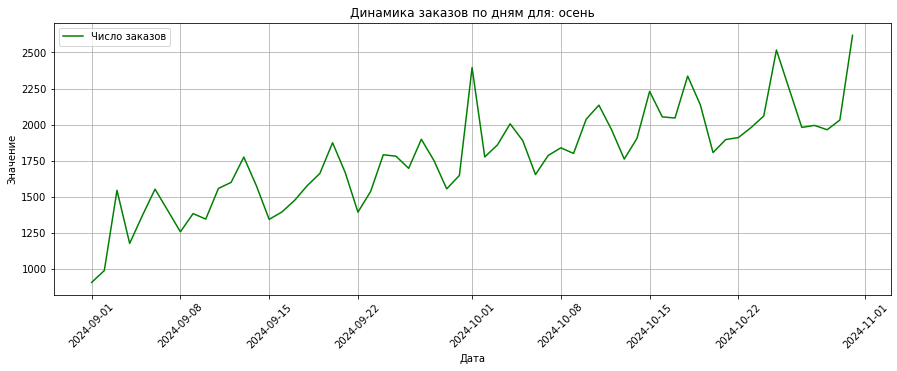

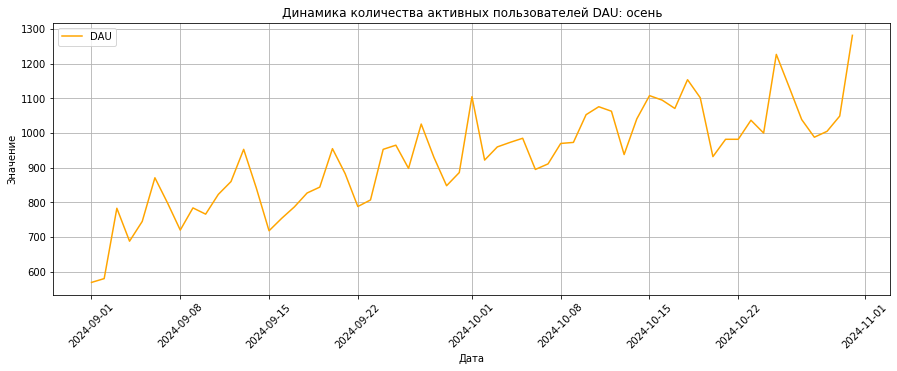

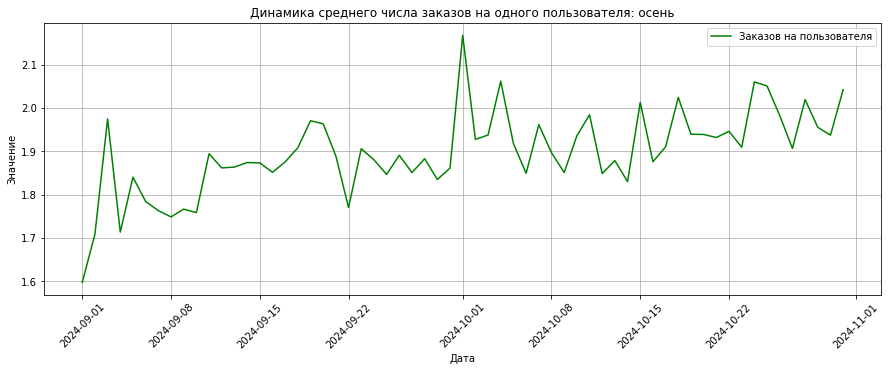

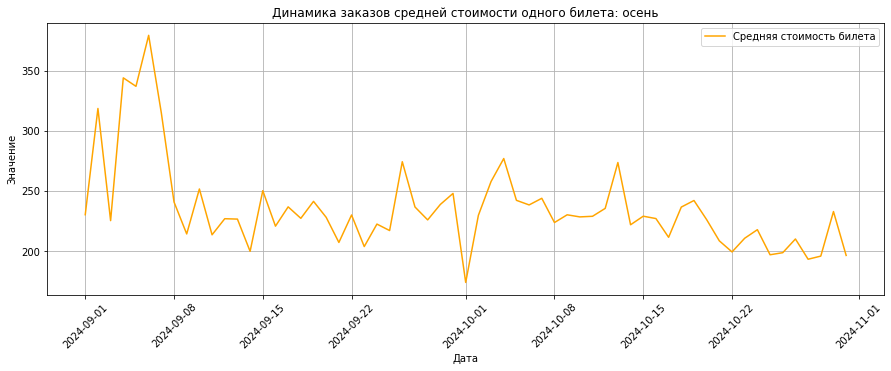

In [45]:
plt.figure(figsize=(15,5))
plt.plot(season_au_table['created_dt_msk'], season_au_table['orders'], label='Число заказов',  color='green')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Значение') 
plt.title('Динамика заказов по дням для: осень')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(season_au_table['created_dt_msk'], season_au_table['users'], label='DAU', color = 'orange')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Динамика количества активных пользователей DAU: осень')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(season_au_table['created_dt_msk'], season_au_table['orders_per_user'], label='Заказов на пользователя', color='green')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Динамика среднего числа заказов на одного пользователя: осень')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(season_au_table['created_dt_msk'], season_au_table['avg_ticket_price'], label='Средняя стоимость билета', color = 'orange')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Динамика заказов средней стоимости одного билета: осень')
plt.legend()
plt.grid(True)
plt.show()


Рост активности: В течение осеннего периода наблюдается устойчивый рост числа заказов, количества активных пользователей (DAU) и среднего числа заказов на одного пользователя. Это отражает общий рост интереса к мероприятиям с началом осеннего сезона.

Пиковые недели: Наибольшая активность приходится на начало октября (2024-10-01), когда фиксируется максимальное количество заказов и пользователей.

Средняя стоимость билета: Наблюдается снижение, особенно в пиковую неделю 2024-10-01. Это может быть связано с увеличением числа массовых мероприятий или акционных предложений, приводящих к уменьшению среднего чека.

Вывод: Осень характеризуется активным ростом пользовательской активности с пиковыми неделями, при этом средний чек может временно снижаться в периоды высокой загрузки и массовых мероприятий.

   day_type   avg_orders   avg_users  avg_orders_per_user  avg_ticket_price
0    Будний  1814.522727  943.613636             1.913583        235.741291
1  Выходной  1665.294118  893.117647             1.852619        235.736455


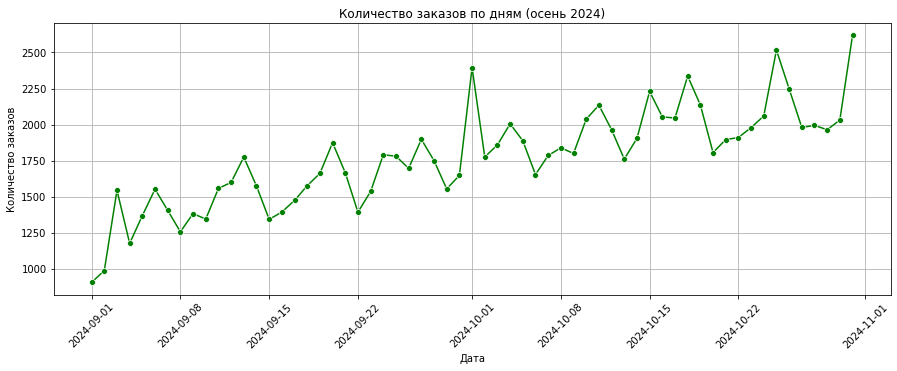

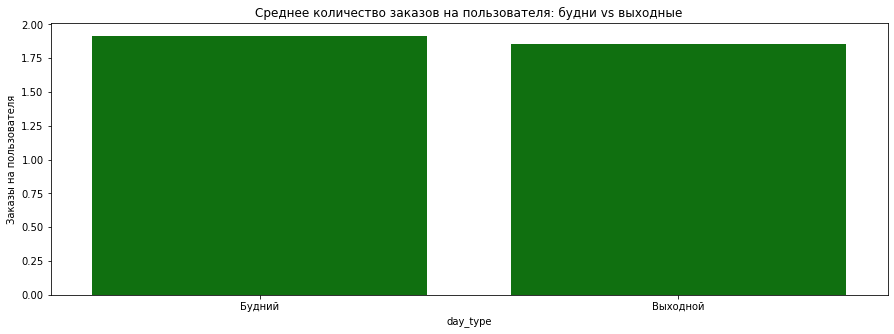

In [46]:
df_season_au['created_dt_msk'] = pd.to_datetime(df_season_au['created_dt_msk'])
season_au_table = df_season_au.groupby('created_dt_msk').agg(
    orders=('order_id', 'count'),
    users=('user_id', 'nunique'),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')
).reset_index()

season_au_table['weekday'] = season_au_table['created_dt_msk'].dt.weekday
season_au_table['day_type'] = season_au_table['weekday'].apply(lambda x: 'Выходной' if x >=5 else 'Будний')
season_au_table['orders_per_user'] = season_au_table['orders'] / season_au_table['users']
weekly_summary = season_au_table.groupby('day_type').agg(
    avg_orders=('orders', 'mean'),
    avg_users=('users', 'mean'),
    avg_orders_per_user=('orders_per_user', 'mean'),
    avg_ticket_price=('avg_ticket_price', 'mean')
).reset_index()

print(weekly_summary)

plt.figure(figsize=(15,5))
sns.lineplot(data=season_au_table, x='created_dt_msk', y='orders', marker='o', color = 'green')
plt.title('Количество заказов по дням (осень 2024)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
sns.barplot(data=weekly_summary, x='day_type', y='avg_orders_per_user', color='green')
plt.title('Среднее количество заказов на пользователя: будни vs выходные')
plt.ylabel('Заказы на пользователя')
plt.show()

Промежуточный вывод по недельной цикличности пользовательской активности:

С начала осени, с сентября по ноябрь, наблюдается стабильный рост общего числа заказов и количества активных пользователей (DAU). Среднее количество заказов на одного пользователя остаётся практически неизменным, а средняя стоимость одного билета также демонстрирует стабильность.
Анализ распределения активности по дням недели показывает небольшие различия: в будние дни пользователи совершают чуть больше заказов, чем в выходные, однако отличие несущественное. В целом, активность пользователей равномерно распределена между буднями и выходными, что говорит о постоянном интересе к мероприятиям в течение всей недели.

In [47]:
season_au_region = (
    df_season_au
    .groupby('region_name')
    .agg(
        events=('event_id', 'nunique'),
        orders=('order_id', 'count')
    )
    .reset_index()
)
total_events = season_au_region['events'].sum()
total_orders = season_au_region['orders'].sum()
season_au_region['events_share_%'] = (season_au_region['events'] / total_events) * 100
season_au_region['orders_share_%'] = (season_au_region['orders'] / total_orders) * 100

season_au_region = season_au_region.sort_values(by='events', ascending=False)
display(season_au_region.head(10))

,region_name,events,orders,events_share_%,orders_share_%
23,каменевский регион,3946,31363,24.780206,28.999806
59,североярская область,2622,14661,16.465712,13.556297
75,широковская область,803,5881,5.042703,5.437868
56,светополянский округ,764,3172,4.797790,2.932991
51,речиновская область,529,2404,3.322030,2.222859
60,серебринская область,456,2946,2.863602,2.724020
76,яблоневская область,432,2751,2.712886,2.543713
67,тепляковская область,420,1597,2.637528,1.476666
11,горицветская область,406,2167,2.549611,2.003717
63,солнечноземская область,403,2196,2.530771,2.030532


In [48]:
season_au_service = (
    df_season_au
    .groupby('service_name')
    .agg(
        events=('event_id', 'nunique'),
        orders=('order_id', 'count'),
        revenue=('revenue_rub', 'sum')
    )
    .reset_index()
)

season_au_service['events_share_%'] = (season_au_service['events'] / season_au_service['events'].sum()) * 100
season_au_service['orders_share_%'] = (season_au_service['orders'] / season_au_service['orders'].sum()) * 100
season_au_service['revenue_share_%'] = (season_au_service['revenue'] / season_au_service['revenue'].sum()) * 100

season_au_service = season_au_service.sort_values(by='revenue', ascending=False)
display(season_au_service.head(10))

,service_name,events,orders,revenue,events_share_%,orders_share_%,revenue_share_%
3,Билеты без проблем,2854,22284,1.639883e+07,16.500925,20.604906,22.604690
24,Мой билет,1012,12663,1.172997e+07,5.851064,11.708846,16.168986
25,Облачко,1413,11047,9.237051e+06,8.169519,10.214611,12.732660
8,Весь в билетах,605,6654,7.402846e+06,3.497919,6.152623,10.204330
21,Лови билет!,3623,16555,7.148483e+06,20.947040,15.307585,9.853707
5,Билеты в руки,2467,12511,4.956116e+06,14.263414,11.568299,6.831675
19,Край билетов,194,2012,2.250341e+06,1.121647,1.860396,3.101946
34,Яблоко,538,2191,1.885039e+06,3.110546,2.025909,2.598401
26,Прачечная,726,3426,1.692969e+06,4.197502,3.167852,2.333645
30,Тебе билет!,859,2519,1.564155e+06,4.966466,2.329194,2.156084


Регионы:

Наибольшее количество уникальных мероприятий и заказов приходится на Каменевский регион и Североярскую область.
Каменевский регион: 3946 мероприятий (≈25% от всех), 31363 заказов (≈29%).
Североярская область: 2622 мероприятия (≈16%), 14661 заказов (≈14%).
Остальные регионы составляют меньшую долю, при этом концентрация заказов и мероприятий сильно снижается уже после топ-2.
Явно видны лидеры по количеству событий и заказов, что позволяет сосредоточить усилия на ключевых регионах для продвижения и оптимизации маркетинга.

Партнёры (сервисные платформы):
Топовые партнёры по количеству выручки и заказов:
Билеты без проблем: 2854 события, 22284 заказа, выручка ≈16,4 млн ₽, доля по выручке ≈23%.
Мой билет: 1012 событий, 12663 заказа, выручка ≈11,7 млн ₽, доля по выручке ≈16%.
Облачко: 1413 событий, 11047 заказа, выручка ≈9,2 млн ₽, доля по выручке ≈13%.
Есть сервисы с меньшей активностью, но они также вносят вклад в общую картину, например «Тебе билет!» и «Прачечная» — небольшое число заказов, но они поддерживают разнообразие платформ.

In [49]:
##Статистический анализ данных

**Нулевая гипотеза (H₀)**: Тип устройства не оказывает влияние на среднее количество заказов на одного пользователя.
**Альтернативная гипотеза (H₁)**: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [50]:
user_metrics = (
    df_season_au.groupby(['user_id', 'device_type_canonical'])
    .agg(
        orders_count=('order_id', 'count'),
        avg_time_between_orders=('days_since_prev', 'mean') 
    )
    .reset_index()
)

mobile = user_metrics[user_metrics['device_type_canonical'] == 'mobile']
desktop = user_metrics[user_metrics['device_type_canonical'] == 'desktop']
intersection = list(set(mobile['user_id']) & set(desktop['user_id']))
print(f'Количество пересечений {len(intersection)}')

print(f"Размер выборки (мобильные): {len(mobile)}")
print(f"Размер выборки (десктоп): {len(desktop)}")

mobile_sample = mobile[~mobile['user_id'].isin(intersection)].sample(n=len(desktop), random_state=42)

print(f"После уравнивания:")
print(f"Мобильные: {len(mobile_sample)}, Десктоп: {len(desktop)}")


Количество пересечений 3137
Размер выборки (мобильные): 14191
Размер выборки (десктоп): 4819
После уравнивания:
Мобильные: 4819, Десктоп: 4819


Мы сравниваем две независимые выборки: пользователей мобильных и десктопных устройств по количеству заказов. Данные не гарантированно нормально распределены и содержат выбросы (разные уровни активности пользователей), поэтому классический t-тест может быть некорректен.

U-тест Манна–Уитни — непараметрический тест, который не требует нормальности распределений и устойчив к выбросам. Он позволяет проверить, есть ли статистически значимая разница в медианах или в общем распределении количества заказов между мобильными и десктопными пользователями.

In [51]:
u_stat_orders, p_value_orders = mannwhitneyu(
    mobile_sample['orders_count'],
    desktop['orders_count'],
    alternative='greater' 
)

print(f"U-statistic: {u_stat_orders:.2f}")
print(f"p-value: {p_value_orders}")

if p_value_orders < 0.05:
    print("Результат статистически значим: мобильные пользователи совершают больше заказов, чем десктопные.")
else:
    print("Статистически значимой разницы между мобильными и десктопными пользователями нет.")

U-statistic: 10887839.50
p-value: 0.9999999993506147
Статистически значимой разницы между мобильными и десктопными пользователями нет.


Разница между мобильными и десктопными пользователями
После исключения пересекающихся пользователей и уравнивания размеров выборок статистически значимой разницы в количестве заказов между мобильными и десктопными пользователями не выявлено (U = 10,887,839.5, p = 0.9999999993506147). Нулевая гипотеза не отклоняется.
В текущем периоде пользователи обеих платформ ведут себя схожим образом по активности. Это значит, что усилия по привлечению заказов можно распределять между мобильной и десктопной аудиториями без явного приоритета.

**H₀ (нулевая гипотеза)**: тип устройства не влияет на среднее время между заказами.
**H₁ (альтернативная гипотеза)**: пользователи мобильных устройств совершают заказы с большим интервалом (реже). Pдесь также уместно использовать Mann–Whitney U-тест, потому что vы сравниваем две независимые выборки (мобильные и десктопные пользователи).
Данные (время между заказами) не обязательно нормально распределены, поэтому непараметрический U-тест подходит лучше, чем t-тест.

In [52]:
u_stat_time, p_value_time = mannwhitneyu(
    mobile_sample['avg_time_between_orders'].dropna(),
    desktop['avg_time_between_orders'].dropna(),
    alternative='greater'
)

print(f"U-statistic: {u_stat_time:.2f}")
print(f"p-value: {p_value_time}")

if p_value_time < 0.05:
    print("Статистически значимая разница: мобильные пользователи совершают заказы реже, чем десктопные.")
else:
    print("Статистически значимой разницы между мобильными и десктопными пользователями нет.")

U-statistic: 7089829.50
p-value: 9.80960092297268e-49
Статистически значимая разница: мобильные пользователи совершают заказы реже, чем десктопные.


Так как p-value < 0.05, нулевая гипотеза отклоняется.
Это означает, что время между заказами действительно больше у пользователей мобильных устройств, чем у пользователей стационарных.

Вывод:
Хотя пользователи мобильных устройств совершают в среднем больше заказов (гипотеза 1), между их покупками наблюдаются более длинные интервалы.
Это может указывать на нерегулярность активности, связанную, например, с более спонтанным поведением при заказах через мобильное приложение.
Для проверки гипотез использовался непараметрический тест Манна–Уитни, так как распределение количества заказов и интервалов между заказами не является нормальным. Для равного сравнения выборки десктопных пользователей были уменьшены до размера мобильной группы.

In [53]:
##Общий вывод и рекомендации

### Информация о данных:
В анализе использовались данные о заказах и мероприятиях за летний и осенний периоды 2024 года. Данные были предварительно очищены: удалены дубликаты, приведены названия столбцов к единому стилю, выполнены необходимые преобразования типов и оптимизирована память. Для анализа учитывались характеристики заказов, пользователей, устройств, категорий мероприятий, регионов и партнёров.

### Основные результаты анализа:

**Динамика заказов**: Общее число заказов активно росло с июня по октябрь, при этом количество уникальных пользователей (DAU) также увеличивалось. Среднее число заказов на одного пользователя и средняя стоимость билета оставались относительно стабильными.

**Сезонные изменения**: С наступлением осени доля заказов сместилась в сторону спортивных и театральных мероприятий. Концерты и массовые театры стали менее доходными по среднему чеку, тогда как стоимость билетов на стендап, спорт и выставки немного выросла.

**Возрастная структура**: Наибольший рост числа заказов осенью наблюдается в возрастных категориях 0–16 лет, а доля заказов для 18+ остаётся примерно на уровне лета.

**Недельная цикличность**: Активность пользователей выше в будние дни по количеству заказов и пользователей, однако разница с выходными незначительна. Средняя стоимость билета и число заказов на пользователя практически не изменяются.

**Тип устройства и результаты проверки гипотез:**

**Гипотеза 1**: Среднее количество заказов на одного пользователя мобильного приложения не отличается статистически значимо от десктопных пользователей (U-статистика - 10 887 839.5, p-value - 1.0).

**Гипотеза 2**: Среднее время между заказами пользователей мобильного приложения статистически больше, чем у десктопных (U-статистика - 7 089 829.5, p-value - 9.809600922), что говорит о том, что мобильные пользователи делают заказы реже, но с большим интервалом.

**Региональное распределение**: Каменевский регион и Североярская область — лидеры по числу мероприятий и заказов (≈40% от общего числа заказов приходится на топ-2 региона).

**Партнёры (сервисные платформы)**: «Билеты без проблем», «Мой билет» и «Облачко» формируют основную долю выручки и заказов, остальные сервисы поддерживают разнообразие предложений.

**Рекомендации:**

* Фокус на ключевых регионах и партнёрах: Каменевский регион, Североярская область и топ-платформы требуют особого внимания для маркетинга и развития предложений.

* Оптимизация цен и ассортимента: Стоимость билетов на массовые мероприятия стоит пересмотреть, а популярные нишевые события — продвигать, так как средний чек на них растёт.

* Мобильные пользователи: Продолжать развивать мобильные приложения и коммуникации, учитывая их высокую активность, но помнить, что заказы у них распределены более равномерно во времени.

* Сезонность: Планирование мероприятий и маркетинговых кампаний стоит учитывать сезонные изменения в предпочтениях пользователей (рост спортивных и театральных событий осенью).

* Дальнейшие исследования: Рассмотреть углублённый анализ поведения пользователей по возрастным категориям, устройствам и типу мероприятий, чтобы точнее прогнозировать спрос и повышать выручку.